In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr

import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression

from causalinference import CausalModel

# Abstract

A core component of vacation planning is reserving accommodations for the duration of a stay. Many vacationers use platforms like Airbnb to immerse themselves in the local experience. Since all listings on Airbnb are owned by hosts, hosts are charged with setting prices for their respective listings. To help with this, Airbnb developed Smart Pricing to dynamically set prices for hosts. Though this tool is available to all hosts, some hosts for different reasons choose to continue to set their own prices. This scenario allows us to perform a "natural experiment" using causal inference techniques to measure the causal impact of the Smart Pricing tool on host revenue. Specifically, we use propensity score matching (PSM) to identify the causal effect of hosts using vs not using dynamic pricing. 

# Introduction

**Airbnb** was founded in 2007 by Brian Chesky and Joe Gebbia. Brian and Joe were short on rent and needed supplemental income to make ends meet. As luck would have it, there was a large conference happening in San Francisco at the time. Brian and Joe decided to "rent" out their living room to conference goers at a fraction of a price of hotels. They provided air mattresses and breakfast for their guests. From this idea, Brian and Joe set out to solve the problem of helping travelers find alternative dwelling arrangements when hotels were at capacity. 

Now, 18 years later, Airbnb is the largest home rental platform in the world. With over 5 million hosts, 8 million listings, and 200 million users. Though at times controversial, Airbnb has revolutionized the travel industry. 

## Airbnb as a Platform

Airbnb can be described as a platform that connects two sides of a market: hosts and guests. Hosts provide the supply by listing their dwellings for rent, while guests create the demand with their preferences for locations, dates, and other criteria. The goal of Airbnb is to help both hosts and guests have "good" experiences on the platform by ensuring that hosts' dwellings are rented and that guests' preferences are met. This cycle is illustrated in Figure @fig-air-1.

![Airbnb Platform](https://fourweekmba.com/airbnb-business-model/airbnb-business-model-3/){#fig-air-1}

Platform businesses like Airbnb face the "chicken or the egg" problem. Guests want to find the right dwelling for their trip, which requires an adequate supply to meet their needs. Likewise, hosts want their dwellings to be rented so they can earn money. Each side of the market is dependent on the other to fulfill its role. Airbnb acts as the "mediator" by attempting to balance this marketplace through various actions like incentives, policies, and technology tools.

# Modeling Market Dynamics

Ensuring the platform runs at peak efficiency is paramount to Airbnb. To do this, we can create models to approximate different market dynamics. For example, [@srinivasan2018] models the lead time of bookings for more robust host pricing mechanisms. 

There are a plethora of different market dynamics that we can model on a platform like Airbnb. However, the dynamics of most interest to Airbnb are the ones we can control. That is, what are the different levers we can adjust to make the market behave as we desire? This area is known as causal inference.

In this post, we focus our causal modeling on the relationship between host revenue earned and the use of Airbnb's dynamic pricing tool, Smart Pricing.

## Dynamic Pricing for Hosts

According to microeconomic theory, price is determined by the supply and demand of a marketplace. Someone trained in economic theory could develop models to understand the trend, seasonality, and other factors that affect supply and demand to best price their product. However, most hosts on Airbnb are not trained economists (and even if they were, they don't have the time or data to model the market). Thus, knowing a good price point to maximize revenue while minimizing lost booking opportunities is a difficult problem.

To reduce this friction for hosts, Airbnb developed Smart Pricing to optimally set prices for hosts based on their developed models. This tool is available to all hosts on the platform. Even though it is freely available, not all hosts use the tool. For example, some hosts may be more aggresive in pricing and want to capture more revenue per booking. 

For Airbnb, an important question is whether there is a true difference in host revenue between those who use Smart Pricing and those who do not. In most scenarios, we would want to run a randomized experiment to easily measure a causal effect. This is no longer feasible since the feature has been rolled out for some time. However, this scenario allows us to analyze a "natural experiment." If we can adjust for the confounding effects of those who opted into the treatment (those who use Smart Pricing) and those who chose not to (those who set their own prices), we can potentially extract a quantified causal effect of dynamic pricing on host revenue.

# Causal Inference

## Propensity Score Matching

Finding causal effects in observational is difficult due to the presence of potential confounders. In randomized control trials like A/B tests, we control for these confounders by isolating the effects of a given treatment through random assignment. In observational studies, we can attempt to control these confounders by balancing the distribution of confounders between "treatment" and "control groups. To do this, we'll use **propensity score matching (PSM)** [@rosenbaum1983].

Propensity Score Matching (PSM) uses the theory that we can control for confounders by matching individuals from both the treated group and the untreated group who have a relatively similar probability of receiving the treatment. In our case, this would involve matching hosts who use Smart Pricing with those who do not, based on their similar probabilities of using Smart Pricing. The flow of causality in this model is shown in @fig-dag-1.

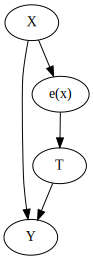

In [2]:
#| label: fig-dag-1
#| fig-cap: DAG for a simple PSM

g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

$e(x)$ is the **propensity score** that we calculate for each individual. With it, we can say that certain features $X$ are a cause of an individuals propensity score, which in turn determines if they use the treatment which ultimately determines the response variable $Y$. The propensity score is the conditional probability of receiving the treatment given certain features $X$. This formula is shown in @eq-prop-1.

$$
e(x) = Pr(T=1|X=x)
$${#eq-prop-1}

Once we generate propensity scores for individuals within our dataset, we match them based on an arbitraty distance criteria that finds the minimum distance between individuals based on propensity scores. In our analysis, we use the KNN algorithm. After creating the matches, we can then calculate our causal estimate, the **average treatment effect (ATE)** (assuming our PSM keeps essential causal model assumptions intact). 

## EDA

In [3]:
#Define data generating function
def gen_data(n_obs, r_seed=42):
    np.random.seed(r_seed)
    
    data_dict = {
        'host_id': [],
        'yrs_host': [],
        'gender': [],
        'use_smart': [],
        'avg_revenue': []
    }
    
    true_params = {
        'true_yrs': 20,
        'true_bed': 10,
        'true_bath': 15,
        'true_gender_f': 5,
        'true_treat': 12
    }
    
    for i in range(n_obs):
        yrs_host = round(np.random.lognormal(.5, .3))
        num_beds = 2
        num_bath = 1
        gender = np.random.choice(['m', 'f'])
        treat = np.random.choice([True, False])
        
        avg_rev = ((true_params['true_yrs'] * yrs_host) + (true_params['true_bed'] * num_beds) + (true_params['true_bath'] * num_bath) 
                  + (true_params['true_gender_f']) * np.where(gender == 'f', 1, 0) + (true_params['true_treat'] * treat) + np.random.normal(5, 2)) 
        
        data_dict['host_id'].append(i)
        data_dict['yrs_host'].append(yrs_host)
        data_dict['gender'].append(gender)
        data_dict['use_smart'].append(treat)
        data_dict['avg_revenue'].append(round(avg_rev,2))
        
    return pd.DataFrame(data_dict)

In [4]:
#Generate synthetic data
df = gen_data(500)

Our data consists of 500 hosts from a single geographic region with similar listing types (in this case, 2 bed, 1 bath listings with similar sq ft). A subset of our data is shown below.

In [5]:
#Show head of data
df.head()

,host_id,yrs_host,gender,use_smart,avg_revenue
0,0,2,m,False,79.72
1,1,1,m,True,72.64
2,2,3,f,True,118.53
3,3,1,m,True,70.95
4,4,2,f,True,93.17


The dataset is a simple datset that consists of only 2 features (*years as host* and *gender*) the treatment binary variable if the host uses Smart Pricing, and the response variable *average revenue* which is the simple average of total revenue over number of bookings (Note: we assume these hosts are booked at a similar frequency).

We begin exploring the data by visualizing the count data of between those who use Smart Pricing in the dataset and those who do not. This is shown in @fig-eda-1.

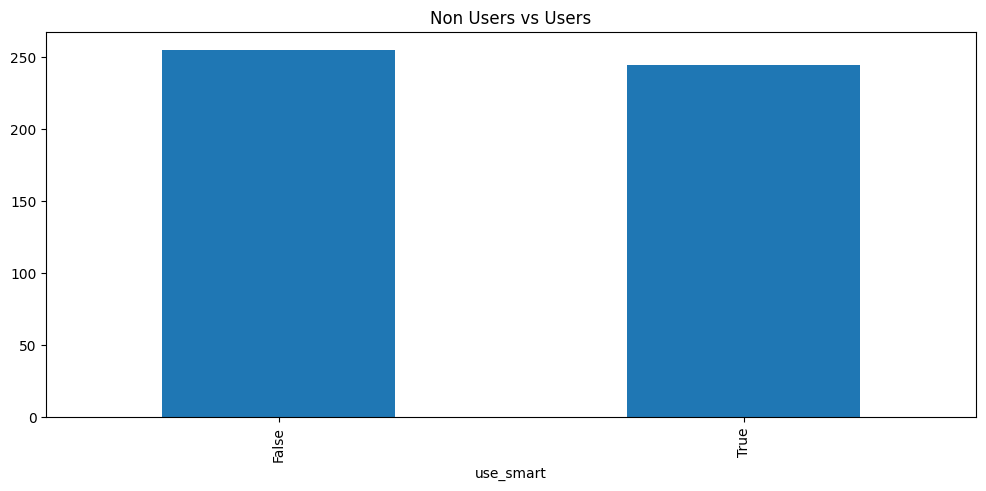

In [6]:
#| label: fig-eda-1
#| fig-cap: "Count of users of smart pricing vs non users"

fig, ax = plt.subplots(figsize=(12,5))

df['use_smart'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Non Users vs Users");

The dataset appears to be fairly evenly split between non users and users of Smart Pricing, with a slight edge to non users. This is a good sign for our causal modeling purposes since a key assumption is good overlap between the treated and untreated. We continue our investigation in @fig-eda-2 by visualizing the average revenue distribution by treated and untreated.

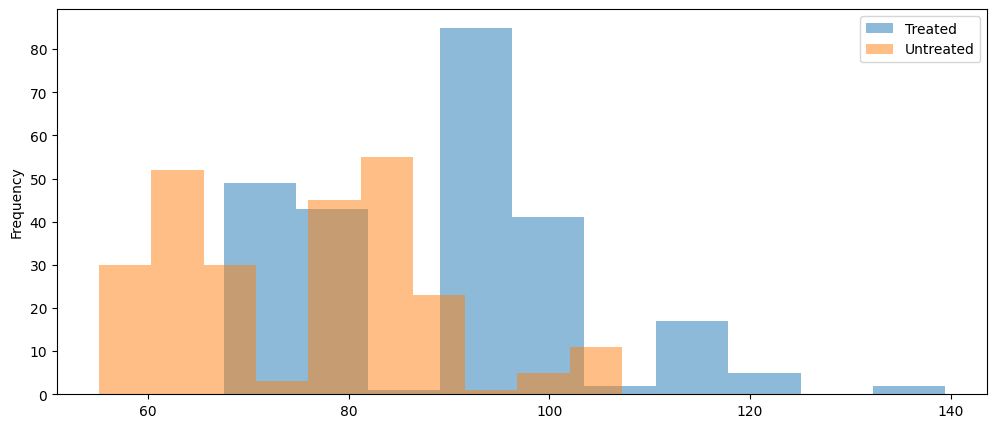

In [7]:
#| label: fig-eda-2
#| fig-cap: "Histogram of treated vs untreated average revenue"

fig, ax = plt.subplots(figsize=(12,5))

df.query("use_smart == True")['avg_revenue'].plot(kind='hist', ax=ax, label='Treated', alpha=0.5)
df.query("use_smart == False")['avg_revenue'].plot(kind='hist', ax=ax, label='Untreated', alpha=0.5)
ax.legend();

@fig-eda-2 shows that the distribution of those who use Smart Pricing is a bit higher than those who do not use it. This is a good indication that Smart Pricing helps hosts have an increase in revenue. We can continue to investigate this relationship in @fig-eda-3.

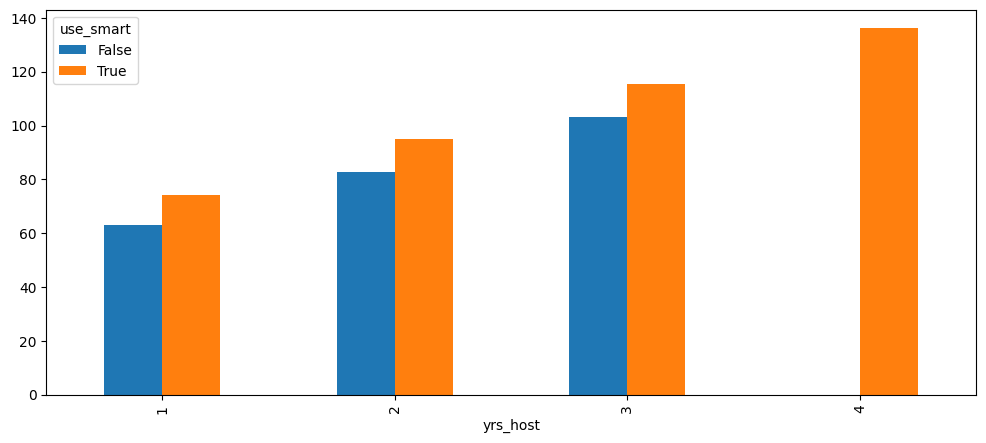

In [8]:
#| label: fig-eda-3
#| fig-cap: "Bar plot comparing average revenue by years as host and smart pricing users"

fig, ax = plt.subplots(figsize=(12,5))

df.groupby(['yrs_host', 'use_smart'])['avg_revenue'].mean().unstack().plot(kind='bar', ax=ax);

There appears to be a relationship between the number of years as a host and the average revenue. While those who use Smart Pricing consistently outperform hosts without Smart Pricing, for each year increase as host, the average revenue increases. One small note is that there aren't any hosts by year 4 who don't use Smart Pricing. We may need to account for this in our model.

## Calculating Propensity Scores

As mentioned previously, once we calculate the propensity scores for our observations, we don't need to account for other attributes $X$ since it adds no additional information that is already captured in the propensity score. To calculate the propensity score, we can use any arbitrary classification model to estimate @eq-prop-1. In our case, we use logistic regression, as shown in @eq-prop-2. Some of our resulting propensity scores are shown in the table below.

$$
log(\frac{p}{1-p}) = \beta^{T}X + \epsilon
$${#eq-prop-2}

In [9]:
#Get dummies and drop unnecessary columns
df_mod = (df.pipe(lambda x: pd.get_dummies(x, columns=['gender']))
 .drop(['host_id', 'gender_m'], axis=1))

In [10]:
#Train logistic and get propensity scores
X = df_mod[['yrs_host', 'gender_f']]
T = df_mod['use_smart']

ps_mod = LogisticRegression().fit(X, T)
df_mod['prop_score'] = ps_mod.predict_proba(X)[:,1]

In [11]:
#Show some output
df_mod.head()

,yrs_host,use_smart,avg_revenue,gender_f,prop_score
0,2,False,79.72,False,0.522335
1,1,True,72.64,False,0.454340
2,3,True,118.53,True,0.569330
3,1,True,70.95,False,0.454340
4,2,True,93.17,True,0.501642


The example output shows some decent balance of propensity scores across the different demographics. We can visualize the scores via histogram overlays, similar to @fig-eda-2. This propensity score histogram is shown below.

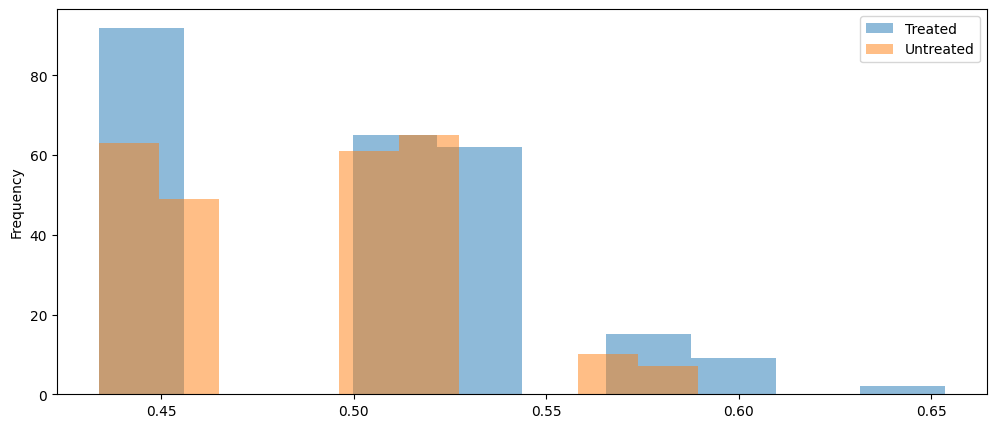

In [12]:
#| label: fig-eda-4
#| fig-cap: "Histogram of propensity scores between treated and untreated hosts"

fig, ax = plt.subplots(figsize=(12,5))

df_mod.query("use_smart == True")['prop_score'].plot(kind='hist', ax=ax, label='Treated', alpha=0.5)
df_mod.query("use_smart == False")['prop_score'].plot(kind='hist', ax=ax, label='Untreated', alpha=0.5)
ax.legend();

The histogram of propensity scores shows pretty good overlap between treated and untreated propensities. There are no scores for untreated hosts on the far right of the distribution (i.e. hosts of 4 years). However, because there is such a small number of individuals in this group, we can proceed.

### Quick Aside on Calculating Propensity Scores

Just a quick note on the propensity scores. Some may believe that a model like logistic regression would be a simple approach to "predicting" treatment. However, the goal of estimating $\hat{e(x)}$ is not to accurately predict treatment. Rather, our $\hat{e(x)}$ estimate should attempt to control for confounding. This slight difference yields very big consequences in the long run of modeling the causal effect of treatment. The high-level explanation is that if we include variables that are only good at predicting the treatment but are not remotely related to the original response variable, then we would be increasing the variance of our propensity score estimates and subsequently breaking important assumptions like overlap (positivity) and biasing our causal effect estimates.

## Causal Effect Estimation via PSM

Since our data appears to hold true on our core causal assumptions, we can proceed with building a model that estimates the causal effect of Smart Pricing on host revenue. In our analysis, we use the `causalinference` [@Shimoni2019] package to fit our data to a Propensity Score Matching (PSM) model. The model takes care of our nearest-neighbor matching (using KNN) and estimates the ATE, ATC, and ATT. @eq-inf-1 shows the math behind each of these estimates. 

$$
ATE = E[Y_{1} - Y_{0}] = E[Y_{1}] - E[Y_{0}]
$$
$$
ATC = E[Y_{1} - Y_{0}|T=0] = E[Y_{1}|T=0] - E[Y_{0}|T=0]
$$
$$
ATT = E[Y_{1} - Y_{0}|T=1] = E[Y_{1}|T=1] - E[Y_{0}|T=1]
$${#eq-inf-1}

The ATE is the difference between the mean of the treated and the mean of the untreated. This holds due to our assumption of unconfoundess via $T \perp (Y_{0}, Y_{1})|e(x)$. This assumption continues to hold for ATC, which is the average treatment effect on the control, meaning the average effect of the treatment if it were to have been applied to the control group. Similarly, the average treatment effect on the treated shows the average effect of the treatment of those who were treated and their counterfactual of if they didn't receive treatment. 

In our analysis, we focus on the ATT since we are dealing with matching. We want to understand how the treatment helped the hosts compared to what could have happened if they didn't use Smart Pricing. The counterfactuals are estimated using the matches in our model. The results for each of these calculations from @eq-inf-1 are shown below.

In [18]:
#Fit PSM and show estimates
cm = CausalModel(
    Y=df_mod["avg_revenue"].values, 
    D=df_mod["use_smart"].values, 
    X=df_mod[["prop_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     12.074      0.194     62.102      0.000     11.693     12.455
           ATC     12.036      0.196     61.447      0.000     11.652     12.419
           ATT     12.114      0.195     62.024      0.000     11.731     12.497



/home/thebscotte/miniconda3/lib/python3.10/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


Our PSM model shows that each of our estimates are statistically significant. The ATT from the model shows that on average, hosts that use Smart Pricing earn \$12 more than those who do not use Smart Pricing. This is a good indication that our dynamic pricing tool helps hosts earn more money per booking. For more context on the scale of this effect, we can review the distribution of untreated hosts.

In [28]:
print(f"Mean: {df.query('use_smart == False')['avg_revenue'].mean()}")
print(f"SD: {df.query('use_smart == False')['avg_revenue'].std()}")

Mean: 75.3310588235294
SD: 12.555868912587034


Looking at the SD, our ATT is almost equal to it. Thus, our ATT says that on average, hosts who use Smart Pricing are essentially one standard deviation above those who don't use Smart Pricing. 

# Conclusion

In this post, we introduced Airbnb, briefly reviewing the company's history, business model, and the pricing tool offered to help hosts in managing their listing(s). Since the pricing tool is optional, Airbnb wanted to know if it actually helps hosts capture more revenue. As a Randomized Control Trial (RCT) wasn't feasible, we proposed using a quasi-experimental method to extract a causal effect. Specifically, we used Propensity Score Matching (PSM) to match those who use Smart Pricing with those who do not. Once we estimated the propensity scores and matched these individuals, we calculated the average causal effects: ATE (Average Treatment Effect), ATC (Average Treatment Effect on the Controls), and ATT (Average Treatment Effect on the Treated). We discovered that our ATT is approximately equal to the standard deviation of revenue for those who don't use Smart Pricing. In business terms, this represents a significant amount of revenue that hosts are missing out on by not using Smart Pricing.

The findings from this post suggest that the current dynamic pricing algorithm is outperforming the self-guided efforts of hosts. The logical next question is: How can we incentivize hosts to use the Smart Pricing tool? Since the Airbnb business model relies on commission from both hosts and guests, the pricing of listings is incredibly important. Getting more hosts to use Smart Pricing would not only yield better monetary results for the hosts but also provide extra revenue for Airbnb.

Additionally, since the dynamic pricing tool has proven successful at improving host listing price dynamics, we should continue to invest resources in optimizing the Smart Pricing tool. We can continue to monitor and model the effect of the Smart Pricing tool on host revenue to ensure that it remains an important lever in improving marketplace efficiency.

Overall, we hope this post demonstrated the usefulness of quasi-experimental techniques in extracting causal inference where RCTs aren't feasible. While the dataset was synthetic and simple, the principles within the post can be applied to a wide array of business problems. With a careful eye and a creative mind, one can find different applications of causal inference in business. 